Import Libraries

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from vit_keras import vit

c:\Users\User\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you'

Dataset Configuration

In [2]:
source_dir = "Malware as Images"
image_size = (224, 224)
batch_size = 32
epochs = 20


Gather File Paths and Integer Labels

In [3]:
file_paths, labels = [], []
for label, category in enumerate(['benign', 'malicious']):
    category_dir = os.path.join(source_dir, category)
    for root, _, files in os.walk(category_dir):
        for fname in files:
            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                fpath = os.path.join(root, fname)
                if os.path.isfile(fpath):
                    file_paths.append(fpath)
                    labels.append(label)

Split Dataset

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(
    file_paths, labels, test_size=0.30, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

TF-Data Pipeline

In [5]:
def process_path(file_path, label):
    img_bytes = tf.io.read_file(file_path)
    img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.resize(img, image_size)
    img = tf.keras.applications.imagenet_utils.preprocess_input(img)
    label = tf.one_hot(label, depth=2)
    return img, label

def make_dataset(X, y, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.apply(tf.data.experimental.ignore_errors())
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(X_train, y_train, shuffle=True)
val_ds = make_dataset(X_val, y_val, shuffle=False)
test_ds = make_dataset(X_test, y_test, shuffle=False)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


Build DeiT-based model

In [6]:
def build_deit_model(num_classes=2, image_size=image_size, patch_size=16):
    backbone = vit.vit_b16(
        image_size=image_size,
        pretrained=True,
        include_top=False,
        pretrained_top=False
    )
    seq_out = backbone.get_layer("Transformer/encoder_norm").output
    seq_model = Model(backbone.input, seq_out)

    def fold_patches(x):
        patch_tokens = x[:, 1:, :]
        return tf.reshape(patch_tokens,
                          (-1, image_size[0]//patch_size, image_size[1]//patch_size, x.shape[-1]))

    x = Lambda(fold_patches)(seq_model.output)
    x = Flatten()(x)
    x = Dense(1000, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(seq_model.input, outputs)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=[
                      'accuracy',
                      tf.keras.metrics.AUC(name='auc'),
                      tf.keras.metrics.FalsePositives(name='false_positives'),
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall'),
                  ])
    return model

model = build_deit_model()
model.summary()

c:\Users\User\anaconda3\Lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input  (None, 197, 768)          151296    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 197, 768),        7087872   
  (TransformerBlock)          (None, 12, None, None)      

Model Training

In [7]:
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('models', exist_ok=True)

checkpoint_cb = ModelCheckpoint('checkpoints/vit_malware_best.h5',
                                monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(train_ds.repeat(), epochs=epochs, steps_per_epoch=80,
                    validation_data=val_ds, callbacks=[checkpoint_cb])

model.save('models/vit_malware_final.h5')

Epoch 1/20



StagingError: in user code:

    File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1154, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\optimizers\optimizer.py", line 544, in minimize
        self.apply_gradients(grads_and_vars)
    File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\optimizers\optimizer.py", line 1223, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\optimizers\optimizer.py", line 652, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\optimizers\optimizer.py", line 1253, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\optimizers\optimizer.py", line 1345, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\optimizers\optimizer.py", line 1342, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\optimizers\optimizer.py", line 241, in _update_step
        self.update_step(gradient, variable)
    File "c:\Users\User\anaconda3\Lib\site-packages\keras\src\optimizers\adam.py", line 199, in update_step
        v.assign_add((tf.square(gradient) - v) * (1 - self.beta_2))
    File "c:\Users\User\anaconda3\Lib\contextlib.py", line 301, in helper
        return _GeneratorContextManager(func, args, kwds)
    File "c:\Users\User\anaconda3\Lib\contextlib.py", line 105, in __init__
        self.gen = func(*args, **kwds)

    MemoryError: 


Plot Training History

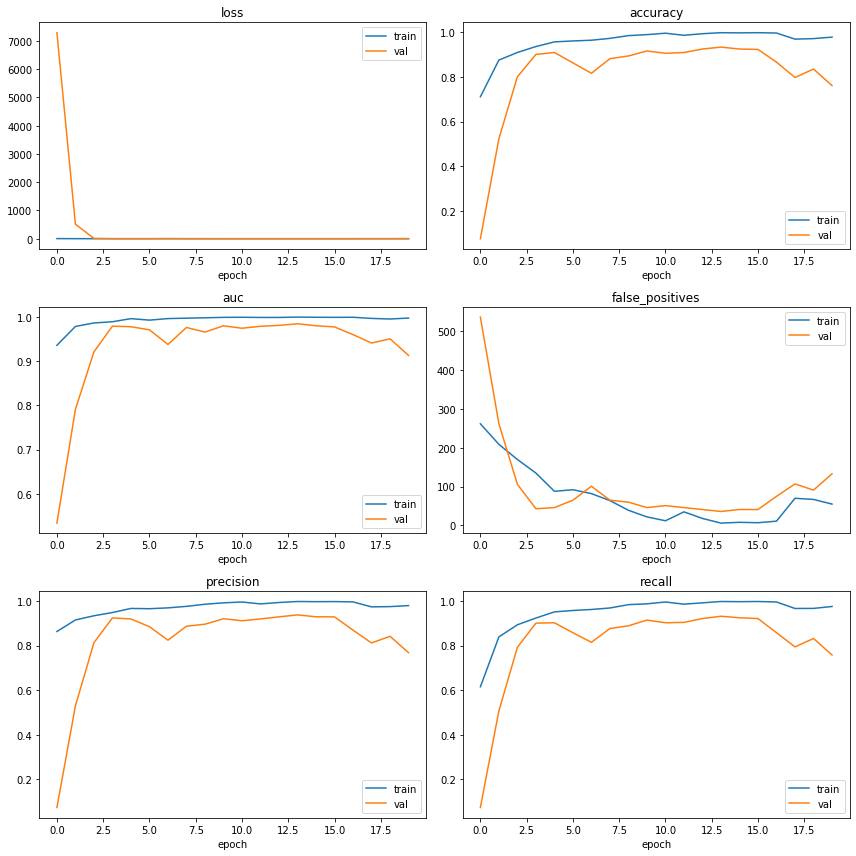

In [ ]:
def plot_history(hist):
    metrics = ['loss', 'accuracy', 'auc', 'false_positives', 'precision', 'recall']
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    for idx, m in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        ax.plot(hist.history[m], label='train')
        ax.plot(hist.history[f'val_{m}'], label='val')
        ax.set_title(m); ax.set_xlabel('epoch'); ax.legend()
    plt.tight_layout(); plt.show()

plot_history(history)

Model Validation

In [ ]:
val_metrics = model.evaluate(val_ds, verbose=1)
print("Validation metrics:")
for name, value in zip(model.metrics_names, val_metrics):
    print(f" - {name}: {value:.4f}")

19/19 [==============================] - 58s 3s/step - loss: 2.8895 - accuracy: 0.7612 - auc: 0.9132 - false_positives: 133.0000 - precision: 0.7683 - recall: 0.7577

Validation set metrics:
 - loss: 2.8895
 - accuracy: 0.7612
 - auc: 0.9132
 - false_positives: 133.0000
 - precision: 0.7683
 - recall: 0.7577


Model Testing

In [ ]:
start = time.time()
preds = model.predict(test_ds)
print(f"Test inference time: {time.time() - start:.2f}s")

y_true = np.argmax(np.vstack([y for _, y in test_ds.unbatch()]), axis=1)
y_pred = np.argmax(preds, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['benign', 'malicious']))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - 70s 3s/step

Inference time on test set: 70.38s

Classification Report:

                precision    recall  f1-score   support

      Adposhel       1.00      1.00      1.00        21
         Agent       0.72      0.72      0.72        18
       Allaple       0.32      0.63      0.42        19
 Alueron.gen!J       1.00      1.00    

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Evaluation

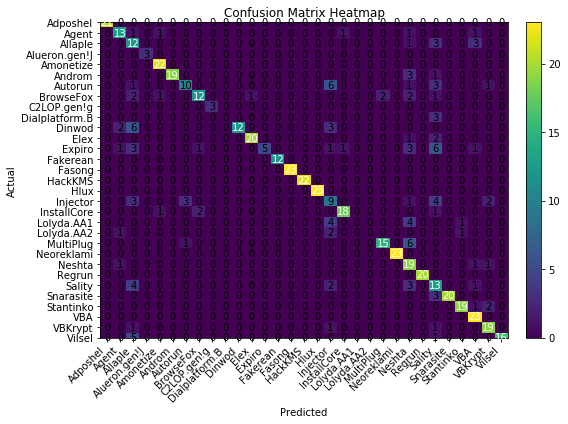

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.colorbar(); plt.xticks([0,1], ['benign', 'malicious'])
plt.yticks([0,1], ['benign', 'malicious'])
th = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i,j], ha='center',
             color='white' if cm[i,j] > th else 'black')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.tight_layout(); plt.show()